In [1]:
import time
import uproot
from datetime import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data.dataset import Subset
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.optimize import curve_fit

In [60]:
# from NetworkUtil import normal_init,Self_Attn,init_weights
# from CosineExp import CosineExpLR
# from InstanceNoise import add_instance_noise
# from RandomScale import random_scale
# from Test_Image import Make_Sample

from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
# scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
# or:
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def add_instance_noise(x, std=0.05):
    if not torch.is_tensor(x):
        x = torch.as_tensor(x)
    noise = torch.randn_like(x) * std
    return x + noise

def random_scale(x, min_scale=0.9, max_scale=1.1):
    if not torch.is_tensor(x):
        x = torch.as_tensor(x)
    scale = (max_scale - min_scale) * torch.rand(x.size(0), 1, device=x.device) + min_scale
    return x * scale

In [39]:
# experiment = Experiment(project_name="CWreg",log_code=True)
# curtime = datetime.now().strftime("%Y%m%d-%H%M%S")
# experiment.set_name("%s"%(curtime))
params={'batch_size' : 200,
        'train_size':80000,
        'val_size':1000,
        'dropout_conv':0.3,
        'dropout_fc':0.0,
        'optim':"Adam",
        'weight_decay':1e-04,
        'Nresblock':5,
        'Nsd':0,
        'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        'ethreshold':0.0,
        'weightstd':1e-03,
        'Nlayer':16,
        'Nfc':0,
        'Nfcnodes':128,
        'Nepoch':5000,
        # 'Nepoch':10,
        # 'learning_rate':0.0000001,# for lr_test
        # 'LRgamma':10,# for lr_test
        # 'stepsize_lr':1, # for lr_test
        # "LRtype":"Step",
        'learning_rate':1e-4,
        'LRgamma':0.998,
        # 'LRgamma':1,
        # 'LRgamma':10,
        'milestones':[200,400,600,800,1000],
        # "LRtype":"MStep",
        # "LRtype":"Cyclic",
        # "LRtype":"CosA",
        "LRtype":"CosExp",
        # "LRtype":"Step",
        # "LRtype":"ROP",
        'noiselevel':1e-05,
        # 'stepsize_lr':50,
        'stepsize_lr':1,
        'stepsize_lr_down':29,
        'ene_reg':False,
        'pos_reg':True,
        'shw_reg':True,
        'base_lr':1e-8,# 10 nano
        'NphoScale':2e5,
        'UVWScale':[40,80,40],
        'SHWScale':[200,1,1],
        'ShowerLengthThreshold':2,
        # 'max_lr':0.005,
        'UsePMT':False,
        'UseLPF':False,
        'DoBlind':False,
        'UseBN':True
}
# experiment.log_parameters(params)
# if params["LRgamma"]>1:
#     experiment.add_tag("LRTest")
# if params["UseLPF"]:
#     experiment.add_tag("LPF")
# if params["pos_reg"]:
#     experiment.add_tag("Pos")
# if params["shw_reg"]:
#     experiment.add_tag("Shw")

In [40]:
import sys

In [43]:
file = uproot.open("~/meghome/xec-ml-wl/CWMC.root")
tout = file["tout"]

In [44]:
device = torch.device('cuda:0')

In [45]:
data = tout.arrays(["energy", "nsum2", "uvw_MC", "gamangle", "shw_vec", "uvw_rec", "Npho"], library="np")
Energy, EneREC, UVW, DIR, SHW, UVWREC, PMResponse = (
    data["energy"].reshape(-1,1),
    data["nsum2"].reshape(-1,1),
    data["uvw_MC"].reshape(-1,3),
    data["gamangle"].reshape(-1,2),
    data["shw_vec"].reshape(-1,3),
    data["uvw_rec"].reshape(-1,3),
    data["Npho"].reshape(-1,4760),
)

In [9]:
print(len(Energy))

86982


(86982, 1)
(86982,)


(array([[1.0000e+01, 4.2000e+01, 4.1000e+01, 3.7000e+01, 9.0000e+00,
         3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 9.0000e+00, 6.0000e+00, 4.0000e+00, 3.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+01, 2.9100e+02, 1.3200e+02, 6.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 6.1000e+01, 4.4800e+02, 3.7700e+02, 1.7000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.9000e+01, 1.9500e+02, 8.2400e+02, 1.0830e+03,
         7.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.0000e+00, 1.3900e+02, 8.5300e+02, 2.7200e+03,
         3.7640e+03, 3.1700e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.5000e+01, 4.3500e+02, 1.9550e+03,
         4.7470e+03, 6.5520e+03, 1.1080e+03, 6.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

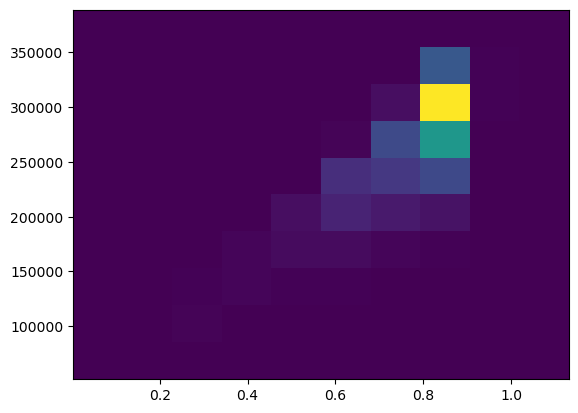

In [46]:
# plt.hist(UVW[:,0])
# plt.show()
# plt.hist(UVW[:,1])
# plt.show()
# plt.hist(UVW[:,2])
# plt.show()
# plt.hist(SHW[:,0])
# plt.show()
# plt.hist(SHW[:,1])
# plt.show()
# plt.hist(SHW[:,2])
# plt.show()
# plt.hist(Energy)
# plt.show()
SumPMResponse = np.sum(PMResponse,axis=1)
print(Energy.shape)
print(SumPMResponse.shape)
plt.hist2d(Energy[:,0],SumPMResponse)

Text(0.5, 1.0, 'Energy')

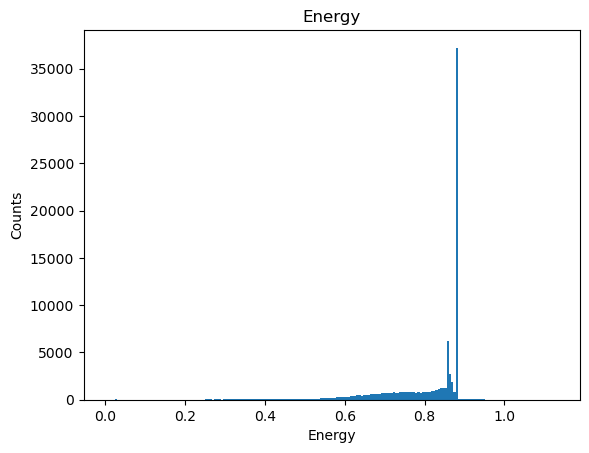

In [47]:
plt.figure()
plt.hist(Energy[:, 0], bins=200)        # increase/decrease as needed
plt.xlabel("Energy"); plt.ylabel("Counts"); plt.title("Energy")

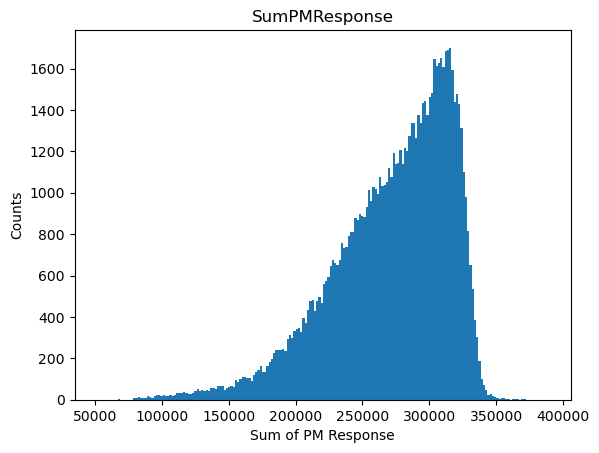

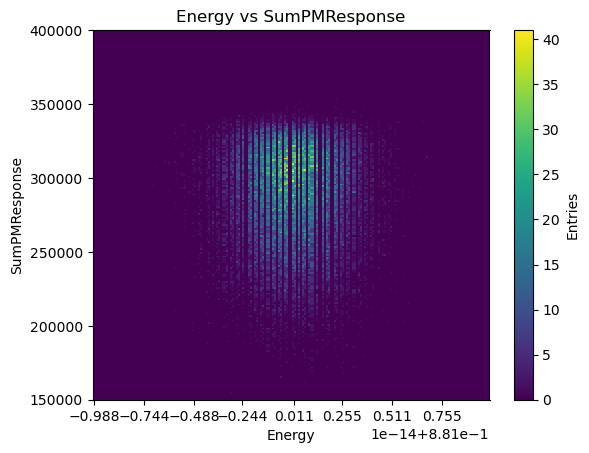

In [48]:
# 1D hist for SumPMResponse
SumPMResponse = PMResponse.sum(axis=1)
plt.figure()
plt.hist(SumPMResponse, bins=200)
plt.xlabel("Sum of PM Response"); plt.ylabel("Counts"); plt.title("SumPMResponse")

# 2D hist with more bins
plt.figure()
plt.hist2d(Energy[:, 0], SumPMResponse, bins=(200, 200), range=((0.88099999999999,0.88100000000001),(15e4,40e4)))
plt.xlabel("Energy"); plt.ylabel("SumPMResponse"); plt.title("Energy vs SumPMResponse")
plt.colorbar(label="Entries")

In [49]:
Energy     = Energy.reshape(-1,1)
EneREC     = EneREC.reshape(-1,1)

## Normalization 
PMResponse = PMResponse/params["NphoScale"]
UVW = UVW/params["UVWScale"]
SHW = SHW/params["SHWScale"]

PMResponse_MPPC,PMResponse_PMT = np.split(PMResponse,[4092],axis=1)
PMResponse_MPPC = PMResponse_MPPC.reshape(-1,93,44)

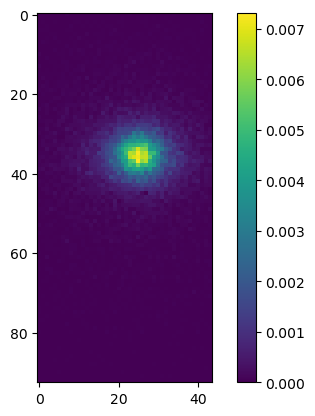

In [ ]:
plt.imshow(PMResponse_MPPC[10])
plt.colorbar()
plt.show()

COSST = 0.5*np.cos(SHW[:,1]).reshape(-1,1)
SINST = 0.5*np.sin(SHW[:,1]).reshape(-1,1)
COSSP = 0.5*np.cos(SHW[:,2]).reshape(-1,1)
SINSP = 0.5*np.sin(SHW[:,2]).reshape(-1,1)
SHW = np.concatenate((SHW[:,0].reshape(-1,1),COSST,SINST,COSSP,SINSP),axis=1)

In [62]:
# ensure np.float32 before converting (good for from_numpy)
Energy  = Energy.astype(np.float32)
EneREC  = EneREC.astype(np.float32)
UVW     = UVW.astype(np.float32)
DIR     = DIR.astype(np.float32)
SHW     = SHW.astype(np.float32)
UVWREC  = UVWREC.astype(np.float32)
PMResponse = PMResponse.astype(np.float32)

Energy     = torch.from_numpy(Energy)
EneREC     = torch.from_numpy(EneREC)
UVW        = torch.from_numpy(UVW)
DIR        = torch.from_numpy(DIR)
SHW        = torch.from_numpy(SHW)
UVWREC     = torch.from_numpy(UVWREC)
PMResponse = torch.from_numpy(PMResponse)

AttributeError: 'Tensor' object has no attribute 'astype'

In [70]:
# start again 

import uproot, numpy as np

params={'batch_size' : 200,
        'train_size':80000,
        'val_size':1000,
        'dropout_conv':0.3,
        'dropout_fc':0.0,
        'optim':"Adam",
        'weight_decay':1e-04,
        'Nresblock':5,
        'Nsd':0,
        'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        'ethreshold':0.0,
        'weightstd':1e-03,
        'Nlayer':16,
        'Nfc':0,
        'Nfcnodes':128,
        'Nepoch':5000,
        # 'Nepoch':10,
        # 'learning_rate':0.0000001,# for lr_test
        # 'LRgamma':10,# for lr_test
        # 'stepsize_lr':1, # for lr_test
        # "LRtype":"Step",
        'learning_rate':1e-4,
        'LRgamma':0.998,
        # 'LRgamma':1,
        # 'LRgamma':10,
        'milestones':[200,400,600,800,1000],
        # "LRtype":"MStep",
        # "LRtype":"Cyclic",
        # "LRtype":"CosA",
        "LRtype":"CosExp",
        # "LRtype":"Step",
        # "LRtype":"ROP",
        'noiselevel':1e-05,
        # 'stepsize_lr':50,
        'stepsize_lr':1,
        'stepsize_lr_down':29,
        'ene_reg':False,
        'pos_reg':True,
        'shw_reg':True,
        'base_lr':1e-8,# 10 nano
        'NphoScale':2e5,
        'UVWScale':[40,80,40],
        'SHWScale':[200,1,1],
        'ShowerLengthThreshold':2,
        # 'max_lr':0.005,
        'UsePMT':False,
        'UseLPF':False,
        'DoBlind':False,
        'UseBN':True
}

file = uproot.open("~/meghome/xec-ml-wl/CWMC.root")
tout = file["tout"]
data = tout.arrays(["energy", "nsum2", "uvw_MC", "gamangle", "shw_vec", "uvw_rec", "Npho"], library="np")

Energy  = data["energy"].reshape(-1, 1)   # (N,1)
EneREC  = data["nsum2"].reshape(-1, 1)    # (N,1)
UVW     = data["uvw_MC"].reshape(-1, 3)   # (N,3)
DIR     = data["gamangle"].reshape(-1, 2) # (N,2)
SHW     = data["shw_vec"].reshape(-1, 3)  # (N,3)
UVWREC  = data["uvw_rec"].reshape(-1, 3)  # (N,3)
PMResponse = data["Npho"].reshape(-1, 4760)  # (N,4760)

# scales (ensure params exists or replace with numbers)
# params = {"NphoScale": 1.0, "UVWScale": 1.0, "SHWScale": 1.0}
PMResponse = PMResponse / params["NphoScale"]
UVW = UVW / params["UVWScale"]
SHW = SHW / params["SHWScale"]

# split sensors
PMResponse_MPPC, PMResponse_PMT = np.split(PMResponse, [4092], axis=1)
PMResponse_MPPC = PMResponse_MPPC.reshape(-1, 93, 44)  # keep if you actually use this tensor

# engineered features for SHW: [theta, cos(theta)/2, sin(theta)/2, cos(phi)/2, sin(phi)/2]
COSST = 0.5 * np.cos(SHW[:, 1]).reshape(-1, 1)
SINST = 0.5 * np.sin(SHW[:, 1]).reshape(-1, 1)
COSSP = 0.5 * np.cos(SHW[:, 2]).reshape(-1, 1)
SINSP = 0.5 * np.sin(SHW[:, 2]).reshape(-1, 1)
SHW   = np.concatenate((SHW[:, [0]], COSST, SINST, COSSP, SINSP), axis=1)  # (N,5)

# sums (only once)
SumPMResponse = PMResponse.sum(axis=1)  # (N,)

# ---- torch conversion without warnings ----
Energy  = Energy.astype(np.float32)
EneREC  = EneREC.astype(np.float32)
UVW     = UVW.astype(np.float32)
DIR     = DIR.astype(np.float32)
SHW     = SHW.astype(np.float32)
UVWREC  = UVWREC.astype(np.float32)
PMResponse = PMResponse.astype(np.float32)

import torch
Energy     = torch.from_numpy(Energy)
EneREC     = torch.from_numpy(EneREC)
UVW        = torch.from_numpy(UVW)
DIR        = torch.from_numpy(DIR)
SHW        = torch.from_numpy(SHW)
UVWREC     = torch.from_numpy(UVWREC)
PMResponse = torch.from_numpy(PMResponse)


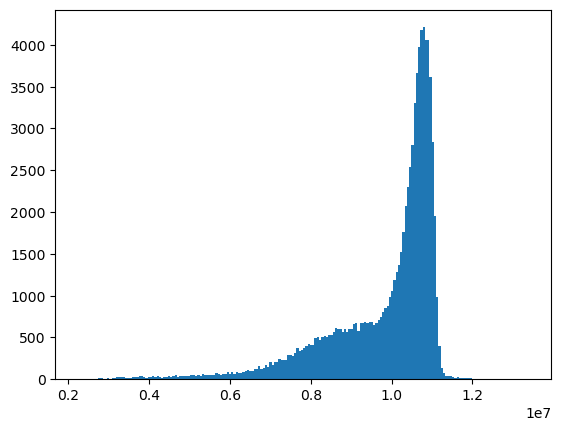

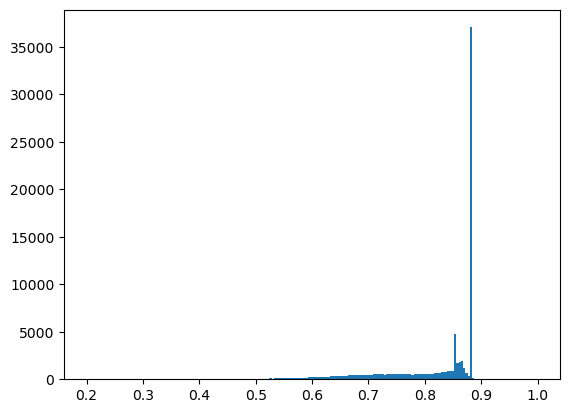

In [81]:
plt.figure()
plt.hist(EneREC, bins=200)
plt.show()
plt.figure()
plt.hist(Energy, bins=200, range=(0.2,1.0))
plt.show()
plt.figure()
plt.hist(PMResponse

In [66]:
class Regressor_simple(nn.Module):
    def __init__(self, Ndim_out,dropout_conv =0.0,dropout_fc=0.0,Nlayer=32,Nresblock=0,Nfcnodes=128,Ndim_cond=0):
        super(Regressor_simple, self).__init__()
        self.conv1 = nn.Conv2d(
            1, 
            Nlayer, 
            kernel_size=(7,6), 
            stride = (4,4), 
            padding = (3,3)
            )#(93+6,44+6)->24,12
        self.conv2 = nn.Conv2d(
            self.conv1.out_channels, 
            self.conv1.out_channels*2, 
            kernel_size=(4, 4), 
            stride=(2,2)
            ,padding = (1,1)
        )#24*12->12*6
        self.conv3 = nn.Conv2d(
            self.conv2.out_channels, 
            self.conv2.out_channels*2, 
            kernel_size=(2, 2), 
            stride=(2,2)
        )#12*6->6*3
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)
        self.bn3 = nn.BatchNorm2d(self.conv3.out_channels)
        Ndim_fcstart = self.conv3.out_channels*18+668
        self.fc1 = nn.Linear(Ndim_fcstart,Nfcnodes)
        self.fc2 = nn.Linear(self.fc1.out_features,1)
        self.dropout1 = nn.Dropout(dropout_conv)
        self.dropoutfc = nn.Dropout(dropout_fc)
        self.leakyReLU = nn.LeakyReLU(0.1)
        
    def forward(self, x, condition = None):
        x = x.view(x.shape[0],-1)
        x_mppc,x_pmt = torch.split(x,4092,dim=1)
        # x_mppc = self.MPPCforward(x_mppc)
        x_mppc = x_mppc.view(x_mppc.shape[0],1,93,44)
        x_mppc = self.leakyReLU(self.dropout1(self.bn1(self.conv1(x_mppc))))
        x_mppc = self.leakyReLU(self.dropout1(self.bn2(self.conv2(x_mppc))))
        x_mppc = self.leakyReLU(self.dropout1(self.bn3(self.conv3(x_mppc))))
        x_mppc = x_mppc.view(x_mppc.shape[0],self.conv3.out_channels*18)
        x = torch.cat([x_mppc,x_pmt],dim=1)
        x = self.leakyReLU(self.dropoutfc(self.fc1(x)))
        x = self.fc2(x)
        return torch.tanh(x)
        # return x

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    def eval_activate(self):
        model.eval()
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.track_running_stats=False

In [68]:
class Regressor_fc(nn.Module):
    def __init__(self, Ndim_out,dropout_conv =0.0,dropout_fc=0.0,Nlayer=32,Nresblock=0,Nfcnodes=128,Ndim_cond=0):
        super(Regressor_fc, self).__init__()
        self.fc1 = nn.Linear(4760,1)
        self.fc2 = nn.Linear(self.fc1.out_features,1)
        self.dropoutfc = nn.Dropout(dropout_fc)
        self.activation = nn.LeakyReLU(0.1)
        
    def forward(self, x, condition = None):
        x = x.view(x.shape[0],-1)
        # x_mppc,x_pmt = torch.split(x,4092,dim=1)
        # # x_mppc = self.MPPCforward(x_mppc)
        # x_mppc = x_mppc.view(x_mppc.shape[0],1,93,44)
        # x_mppc = F.relu(self.dropout1(self.conv1(x_mppc)))
        # x_mppc = F.relu(self.dropout1(self.conv2(x_mppc)))
        # x_mppc = x_mppc.view(x_mppc.shape[0],self.conv2.out_channels*72)
        # x = x_mppc
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return torch.tanh(x)
        # return x

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    def eval_activate(self):
        model.eval()
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.track_running_stats=False

In [69]:
Ndim_out = 0
if params["pos_reg"]:
    Ndim_out += 3
if params["shw_reg"]:
    Ndim_out += 5

Ndim_cond = 0
if params["UseLPF"]:
    Ndim_cond += 3

# model = Regressor_MEG(
#     Ndim_out,
#     params["dropout_conv"],
#     params["dropout_fc"],
#     params['Nlayer'],
#     params['Nresblock'],
#     params['Nfcnodes'],
#     Ndim_cond
#     ).to(device)
model = Regressor_simple(
    Ndim_out,
    params["dropout_conv"],
    params["dropout_fc"],
    params['Nlayer'],
    params['Nresblock'],
    params['Nfcnodes'],
    Ndim_cond
    ).to(device)    
# model = Regressor_fc(
#     Ndim_out,
#     params["dropout_conv"],
#     params["dropout_fc"],
#     params['Nlayer'],
#     params['Nresblock'],
#     params['Nfcnodes'],
#     Ndim_cond
#     ).to(device)    
print(model)
model.weight_init(mean=0.0, std=params['weightstd'])
# model.apply(init_weights)

Regressor_simple(
  (conv1): Conv2d(1, 16, kernel_size=(7, 6), stride=(4, 4), padding=(3, 3))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1820, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropoutfc): Dropout(p=0.0, inplace=False)
  (leakyReLU): LeakyReLU(negative_slope=0.1)
)


NameError: name 'normal_init' is not defined